# Decision Trees

In [46]:
import pandas as pd
import numpy as np
import random
from sklearn import model_selection, metrics, tree, ensemble
import matplotlib.pyplot as plt

Please see our GitHub pdf if you require a refresher on the concept of decision trees: https://github.com/IKMLab/decision-tree-and-random-forest-tutorial/blob/master/decision_tree.pdf. These slides use a different dataset.

We will use the South African heart disease dataset we were using for logistic regression. We will see if we can beat our previous best test set accuracy.

Much of the data preparation phase is the same as we have seen in the last three tutorials so we will not explain it. The code should be clear to you by now hopefully.

## Load and Prepare Data

In [ ]:
file_name = 'SAheart.data.csv'
data = pd.read_csv(file_name, index_col=0)
data.head()

### Categorial Variables

With decision trees we don't need to split categorical variables into binary variables because the decision tree is able to make it's decisions based on the labels.

However we do have to change them into integer labels, not strings. We will make `Present` equal to `1` and `Absent` equal to `0`.

In [ ]:
data['famhist'] = data['famhist'] == 'Present'

### Train-Test Split

Let's control randomization for a fair comparison

In [ ]:
random.seed(42)
np.random.seed(42)
train, test = model_selection.train_test_split(data)

### Split Features and Response

In [ ]:
x_train = train.loc[:, train.columns != 'chd']
y_train = train['chd']
x_test = test.loc[:, test.columns != 'chd']
y_test = test['chd']
splits = (x_train, y_train, x_test, y_test)

## Fit Baseline Model

We will use `sklearn.tree.DecisionTreeClassifier` to fit this data - reference here http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html.

### Bias-Variance Trade-Off

How do we control regularization and model complexity with decision trees? Let's consider some of the hyperparameters of the model listed in the documentation. (We won't cover all - the documentation lists them all). Consider `max_depth`: how many decisions the tree can make. The more decisions we can make the more flexible our model is. Also consider `min_samples_split` and `min_samples_leaf`. With the default minimum of 1 sample per leaf and an unlimited depth, our decision tree will complete fit the data. Let's try that first and see the result.

In [39]:
def train_and_evaluate(model, splits):
    x_train, y_train, x_test, y_test = splits
    model.fit(x_train, y_train)
    preds_train = model_bl.predict(x_train)
    preds_test = model_bl.predict(x_test)
    acc_train = metrics.accuracy_score(y_train, preds_train)
    acc_test = metrics.accuracy_score(y_test, preds_test)
    print('Training accuracy: %s' % acc_train)
    print('Testing accuracy: %s' % acc_test)

model_bl = tree.DecisionTreeClassifier()
train_and_evaluate(model_bl, splits)

Training accuracy: 1.0
Testing accuracy: 0.5603448275862069


We have totally fit the training data - training accuracy is 100%. We can congratulate ourselves. But wait, testing data is terrible at 55%? This is even worse than our much simpler logistic regression model. This is terrible overfitting.

For our baseline let's try limiting the depth of the tree. Let's try some values to see the difference.

In [40]:
model_bl = tree.DecisionTreeClassifier(max_depth=5)
train_and_evaluate(model_bl, splits)

Training accuracy: 0.8005780346820809
Testing accuracy: 0.6551724137931034


In [41]:
model_bl = tree.DecisionTreeClassifier(max_depth=1)
train_and_evaluate(model_bl, splits)

Training accuracy: 0.6994219653179191
Testing accuracy: 0.6724137931034483


In [42]:
model_bl = tree.DecisionTreeClassifier(max_depth=3)
train_and_evaluate(model_bl, splits)

Training accuracy: 0.7312138728323699
Testing accuracy: 0.6896551724137931


We can see that even considering a depth of 5 this dataset is overfitting. With a depth of 1 we are underfitting. A depth of 2-3 is a bit better.

This is of course just to consider one of our hyperparameters. Experiment now with other hyperparameters (refer to the documentation http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and get a feeling for what they do. There is no need to work for the best score just yet. But do get a feeling for what the hyperparameters do and how they control the bias-variance trade-off.

In [ ]:
"""
Task: Experiment with the decision tree hyperparameters
"""


## Ensembling

A nice trick we can use to reduce the variance of our models is to train many models and average their predictions. This is called **ensemble learning** (https://en.wikipedia.org/wiki/Ensemble_learning).

Ensembling can work with the same model trained on different subsets of the original training data randomly sampled with replacement. This is a technqiue known as **bootstrap aggregating** (https://en.wikipedia.org/wiki/Bootstrap_aggregating).

It can also work with different models - e.g. a decision tree classifier and a logistic regression classifier together.

## Random Forests

Ensembling with decision trees has its own special algorithm: **random forests**. We train a number of decision trees on randomly sampled subsets of the data and average the predictions.

We can implement a random forest with `sklearn.ensemble.RandomForestClassifier` - reference here http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html.

We have mostly the same hyperparameters as decision trees but we have one important new one: `n_estimators`. This controls how many trees in the forest, and correspondingly how big the benenficial effects of ensembling are. The trade-off is computation time - with a very large dataset this might be a problem. With our small dataset it will not be a problem.

Let's find the value of `n_estimators` of our baseline decision tree beyond which we can't improve. We will of course use **cross validation** on the training set, **not** the test set, to find this value.

Running the next cell may nevertheless take a minute, be patient!

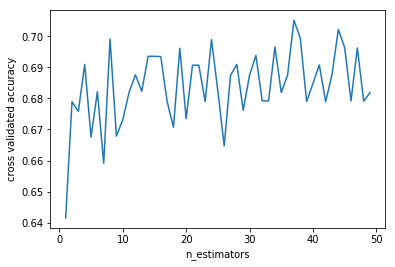

In [51]:
def scorer(model, X, y):
    preds = model.predict(X)
    return metrics.accuracy_score(y, preds)

max_n = 50
accs = []
for n in range(1, max_n):
    model = ensemble.RandomForestClassifier(max_depth=3, n_estimators=n)
    acc = model_selection.cross_val_score(model, x_train, y_train, cv=10, scoring=scorer)
    accs.append(acc.mean())

plt.plot(range(1, max_n), accs)
plt.xlabel('n_estimators')
plt.ylabel('cross validated accuracy')
plt.show()

Examine this plot. What do you think is the value of `n_estimators` beyond which there is no clear benefit? I will choose 20 as it seems the pattern has roughly settled down.

## Challenge

Tune a random forest by finding the hyperparameters that give you the best test set accuracy you can find. Refer to the documentation for `sklearn.ensemble.RandomForestClassifier` (http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Feel free to use a grid search (refer to the grid search example from the logistic regression tutorial if necessary: https://github.com/IKMLab/Logistic-Regression-Tutorial/blob/publish/logistic_regression_tutorial.ipynb).

At the end, compare your best test set accuracy with your result with logistic regression. Which is the better classifier for this task for you?

In [ ]:
"""
Task: Find the best random forest model and compare your test accuracy with logistic regression
"""
